# Predict Bike Sharing Demand With Autogluon Notebook

This notebook should be using an `ml.t3.medium` instance (2 vCPU + 4 GiB)

## Download the Kaggle Dataset

### Install Packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle 

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
  Using cached setuptools-76.0.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-76.0.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.18.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-table==5.0.0, which is not installed.
dash 2.18.1 requires Flask<3.1,>=1.0.4, but you have flask 3.1.

### Install Packages

In [32]:
import os
import shutil
import json
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns

### Setup Kaggle API Key

In [14]:
# Load credentials from .env 
load_dotenv()

# Retrieve Kaggle credentials
kaggle_username = os.getenv("KAGGLE_USERNAME")
kaggle_key = os.getenv("KAGGLE_KEY")

# Ensure the ~/.kaggle directory exists
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Save API token to kaggle.json
kaggle_config_path = os.path.join(kaggle_dir, "kaggle.json")

with open(kaggle_config_path, "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Set correct file permissions
os.chmod(kaggle_config_path, 0o600)

print(" Kaggle API credentials stored securely at:", kaggle_config_path)

In [17]:
os.environ["KAGGLE_CONFIG_DIR"] = "/home/ec2-user/.kaggle"

In [18]:
os.chmod("/home/ec2-user/.kaggle/kaggle.json", 0o600)

In [19]:
# download the dataset
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip -d data/

Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


### Download and Explore the Dataset

In [1]:
# Preview the training Dataset
train_df = pd.read_csv("data/train.csv")
train_df.head()

NameError: name 'pd' is not defined

In [28]:
# Preview the test dataset
test_df = pd.read_csv("data/test.csv")
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [56]:
# Preview the submission dataset
submission_df = pd.read_csv("data/sampleSubmission.csv")
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### Create a Correlation Matrix to understand features

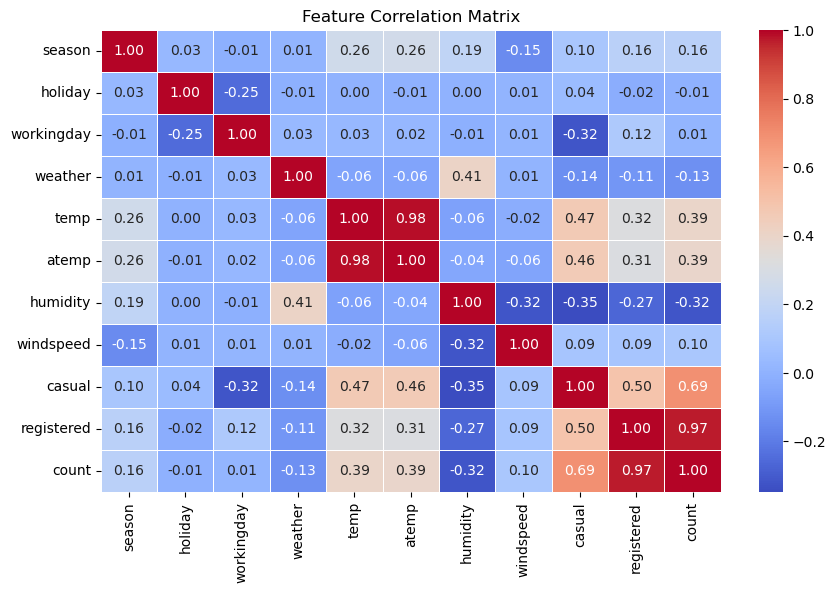

In [33]:
# Extract Numeric Features only
numeric_features = train_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Removing Features to prevent data leakage or due to High collinearity
 - `Casual` and `registered` will be removed to prevent data leakage as they sum up to `count` which is our target variable and these are not available in real time
 - `atemp` will be removed due to multicollinearity (0.98) so the model does not neglect other important features  

In [34]:
# dropping casual, registered and atemp columns
train_df.drop(columns=['casual','registered', 'atemp'], inplace=True)

In [36]:
# check columns are dropped
train_df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


## Create an initial model to get a baseline score

In [ ]:
predictor_baseline = TabularPredictor(label="count", 
                             eval_metric='rmse').fit(
    train_data=train_df,
    time_limit=600,
    presets='best_quality'
)

### Explore the Results

In [ ]:
%%capture
# Get the fit summary (without extra text)
baseline_summary = predictor_baseline.fit_summary()

In [50]:
# Extract and print only the top 5 models with key columns
print(baseline_summary["leaderboard"][["model", "score_val", "fit_time", "pred_time_val"]].head(5))

                    model  score_val    fit_time  pred_time_val
0     WeightedEnsemble_L3 -52.982261  335.457640      22.879514
1  RandomForestMSE_BAG_L2 -53.329503  261.429296      18.798376
2         LightGBM_BAG_L2 -54.895963  244.221869      18.108559
3       LightGBMXT_BAG_L2 -60.252267  271.140563      21.506510
4   KNeighborsDist_BAG_L1 -84.125061    0.036911       0.057936


Text(0.5, 0.98, 'Leaderboard of Best Performing Baseline Models')

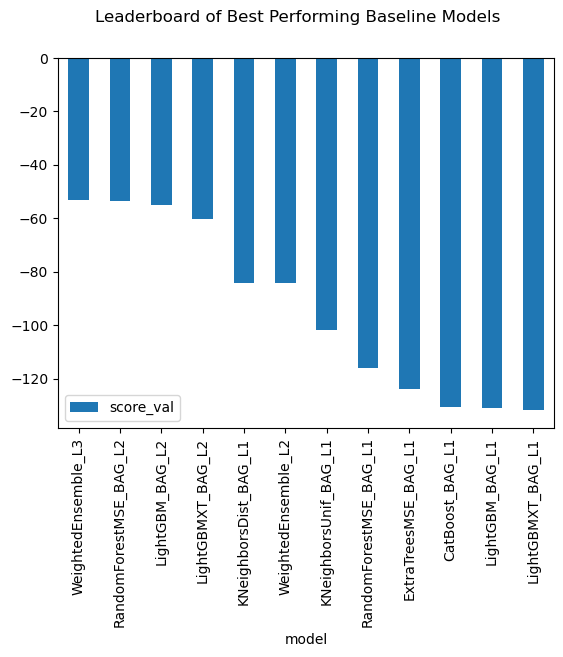

In [48]:
# Graphically view the best models
predictor_baseline.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')
plt.suptitle("Leaderboard of Best Performing Baseline Models")

### Create Baseline Predictions from test df 

In [51]:
baseline_predictions = predictor_baseline.predict(test_df)
baseline_predictions.head()

0    23.968403
1    40.883957
2    45.808838
3    49.023182
4    51.523621
Name: count, dtype: float32

### Submit Baseline Predictions to Kaggle

In [52]:
# Describe the predictions data
baseline_predictions.describe()

count    6493.000000
mean      100.600685
std        89.882912
min         3.103891
25%        19.781649
50%        64.523422
75%       168.910843
max       368.220184
Name: count, dtype: float64

In [54]:
# replace any negative values with '0'
baseline_predictions = baseline_predictions.clip(lower=0)

# Check no negative values exist
(baseline_predictions<0).sum()

0

In [58]:
# Initialise submissions df from submissions example
submission_baseline_df = submission_df

# populate count column with predictions
submission_baseline_df["count"] = baseline_predictions

# Convert to csv
submission_baseline_df.to_csv("baseline_submission.csv", index=False)

In [59]:
submission_baseline_df.head()

,datetime,count
0,2011-01-20 00:00:00,23.968403
1,2011-01-20 01:00:00,40.883957
2,2011-01-20 02:00:00,45.808838
3,2011-01-20 03:00:00,49.023182
4,2011-01-20 04:00:00,51.523621


In [60]:
!kaggle competitions submit -c bike-sharing-demand -f baseline_submission.csv -m "Baseline Submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 656kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
# View the Score of Baseline Submission
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                        description                        status                     publicScore  privateScore  
------------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
baseline_submission.csv         2025-03-17 17:37:12.007000  Baseline Submission                SubmissionStatus.COMPLETE  1.79680      1.79680       
submission_new_hpo.csv          2025-03-17 11:44:10.980000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.50480      0.50480       
submission_new_features_v2.csv  2025-03-17 10:40:59.687000  even more new features             SubmissionStatus.COMPLETE  0.60253      0.60253       
submission_new_features.csv     2025-03-17 10:17:23.553000  new features                       SubmissionStatus.COMPLETE  1.79567      1.79567       


## Baseline Model Summary
### The best Baseline model was the **WeightedEnsemble_L3** with an RMSE score of **52.982261** and a Kaggle score of **1.79680**.
- We will now aim to improve this score further by performing feature engineering and hyperparameter tuning.


# Feature Engineering
- We will now perform some further EDA and create new features
- We will then rerun tabular predictor and attempt to improve upon the baseline performance.